<a href="https://colab.research.google.com/github/hey-mano/COVID-19/blob/master/postblock3/q6/post_block_3_question6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PySpark in Google Colab

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

# Ingest Data

In [2]:
import requests
path = "https://storage.googleapis.com/bdt-demand-forecast/sales-data.csv"
req = requests.get(path)
url_content = req.content

csv_file_name = 'sales-data.csv'
csv_file = open(csv_file_name, 'wb')

csv_file.write(url_content)
csv_file.close()

df = spark.read.csv('/content/'+csv_file_name, header=True, inferSchema=True)

In [3]:
df.show(5)

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
+----------+-----+----+-----+
only showing top 5 rows



# Check Missing Values

In [4]:
from pyspark.sql import functions as F

# Count missing values for each column
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the results
missing_values.show()

+----+-----+----+-----+
|date|store|item|sales|
+----+-----+----+-----+
|   0|    0|   0|    0|
+----+-----+----+-----+



# Check Date Range

In [5]:
from pyspark.sql.functions import min, max

date_range = df.select(min("date").alias("min_date"), max("date").alias("max_date")).collect()

min_date = date_range[0]["min_date"]
max_date = date_range[0]["max_date"]

print(f"Date range: {min_date} to {max_date}")

Date range: 2013-01-01 to 2017-12-31


# Data Partition

Only use sales data before the year 2016

In [48]:
from pyspark.sql.functions import col

df = df.withColumn("date", col("date").cast("date"))

# partitioning dates
train_end_date = "2016-12-31"

# training, validation, and test sets
train_df = df.filter(col("date") <= train_end_date)
test_df = df.filter((col("date") > train_end_date))

# counts of each partition
print("Training set count:", train_df.count())
print("Test set count:", test_df.count())

Training set count: 730500
Test set count: 182500


# Make Temp View

In [49]:
# make the dataframe queryable as a temporary view
train_df.createOrReplaceTempView('train_df')

In [50]:
%pip install prophet

# Single-Forecast

In [51]:
# query to aggregate data to date (ds) level
sql_statement = '''
  SELECT
    CAST(date as date) as ds,
    sales as y
  FROM train_df
  WHERE store=1 AND item=1
  ORDER BY ds
  '''

# assemble dataset in Pandas dataframe
history_pd = spark.sql(sql_statement).toPandas()

# drop any missing records
history_pd = history_pd.dropna()

In [52]:
from prophet import Prophet
import logging

# disable informational messages from prophet
logging.getLogger('py4j').setLevel(logging.ERROR)

## Train Prophet Model

In [53]:
# set model parameters
model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='multiplicative'
  )

# fit the model to historical data
model.fit(history_pd)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gjc4ouo/4myd85sm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gjc4ouo/zzrux5vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99015', 'data', 'file=/tmp/tmp0gjc4ouo/4myd85sm.json', 'init=/tmp/tmp0gjc4ouo/zzrux5vi.json', 'output', 'file=/tmp/tmp0gjc4ouo/prophet_model3pii1tsy/prophet_model-20241103214213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
# define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
  periods=90,
  freq='d',
  include_history=True
  )

# predict over the dataset
forecast_pd = model.predict(future_pd)

display(forecast_pd)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,15.579717,1.801535,18.266324,15.579717,15.579717,-0.352445,-0.352445,-0.352445,-0.082364,-0.082364,-0.082364,-0.270081,-0.270081,-0.270081,0.0,0.0,0.0,10.088731
1,2013-01-02,15.585508,2.262068,18.761087,15.585508,15.585508,-0.328516,-0.328516,-0.328516,-0.057914,-0.057914,-0.057914,-0.270602,-0.270602,-0.270602,0.0,0.0,0.0,10.465424
2,2013-01-03,15.591299,2.087815,18.571543,15.591299,15.591299,-0.309486,-0.309486,-0.309486,-0.037536,-0.037536,-0.037536,-0.271950,-0.271950,-0.271950,0.0,0.0,0.0,10.766011
3,2013-01-04,15.597090,3.509764,20.339858,15.597090,15.597090,-0.212825,-0.212825,-0.212825,0.061226,0.061226,0.061226,-0.274051,-0.274051,-0.274051,0.0,0.0,0.0,12.277646
4,2013-01-05,15.602880,4.843081,22.159745,15.602880,15.602880,-0.133616,-0.133616,-0.133616,0.143190,0.143190,0.143190,-0.276806,-0.276806,-0.276806,0.0,0.0,0.0,13.518080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,2017-03-27,22.804210,9.293299,25.987549,22.788467,22.820293,-0.214075,-0.214075,-0.214075,-0.218628,-0.218628,-0.218628,0.004553,0.004553,0.004553,0.0,0.0,0.0,17.922388
1547,2017-03-28,22.807735,12.743715,30.213490,22.791875,22.824052,-0.073689,-0.073689,-0.073689,-0.082364,-0.082364,-0.082364,0.008675,0.008675,0.008675,0.0,0.0,0.0,21.127061
1548,2017-03-29,22.811260,13.803514,30.454424,22.795183,22.827811,-0.045151,-0.045151,-0.045151,-0.057914,-0.057914,-0.057914,0.012763,0.012763,0.012763,0.0,0.0,0.0,21.781315
1549,2017-03-30,22.814785,14.163140,30.728450,22.798482,22.831570,-0.020694,-0.020694,-0.020694,-0.037536,-0.037536,-0.037536,0.016842,0.016842,0.016842,0.0,0.0,0.0,22.342661


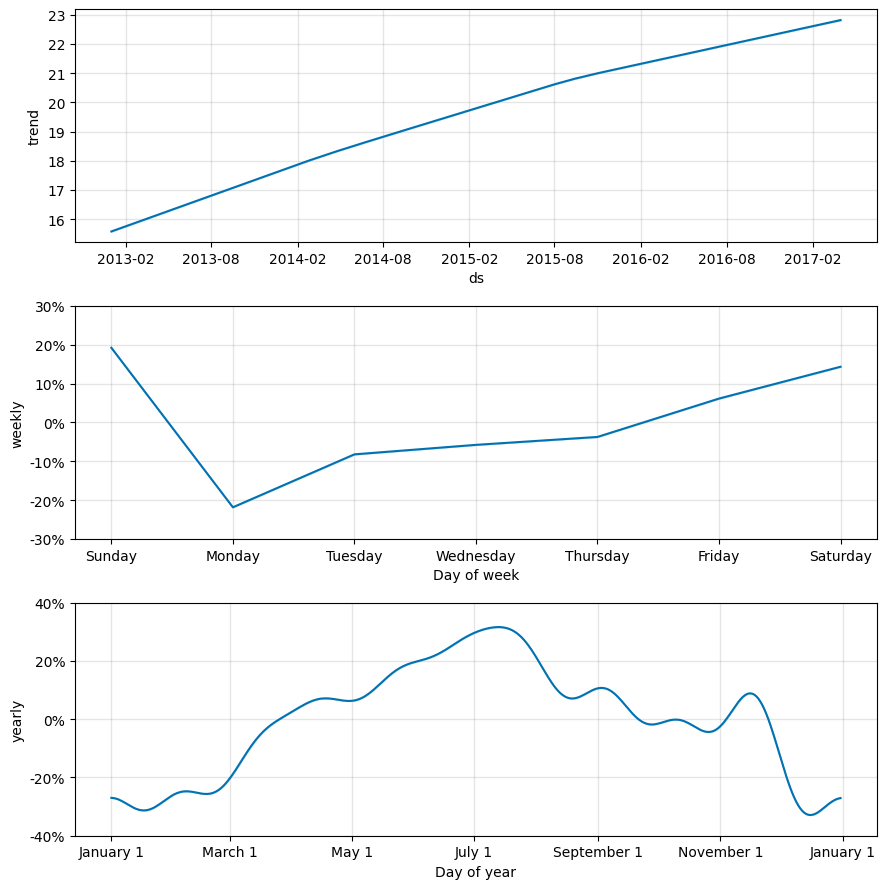

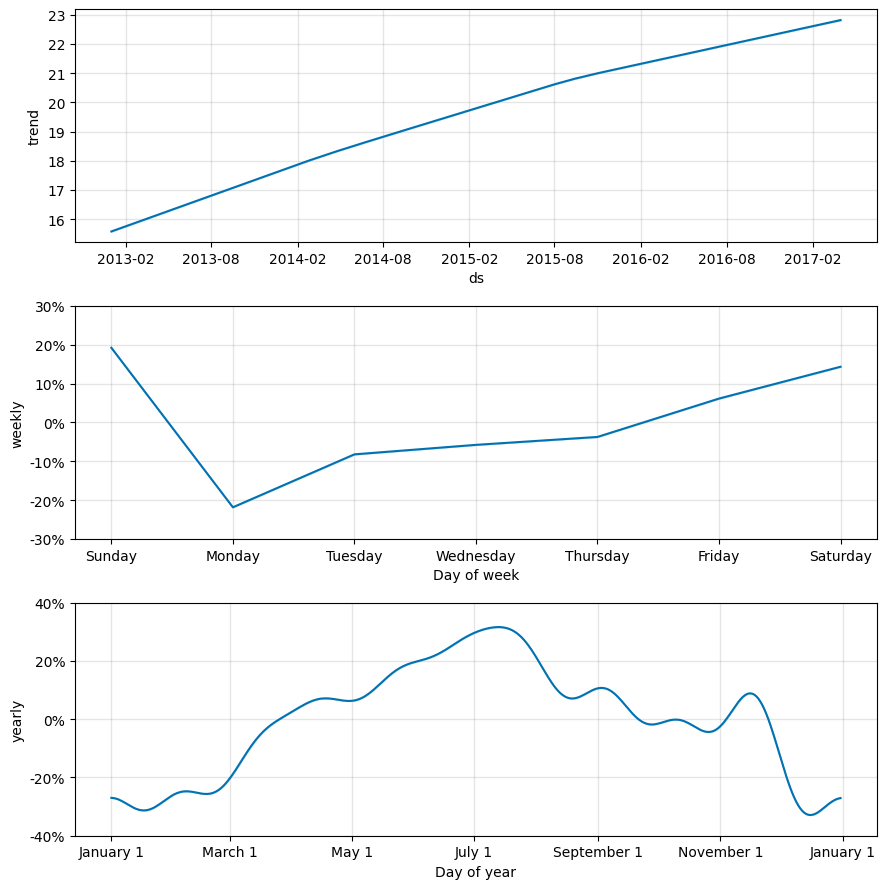

In [55]:
trends_fig = model.plot_components(forecast_pd)
display(trends_fig)

## History vs. Predictions

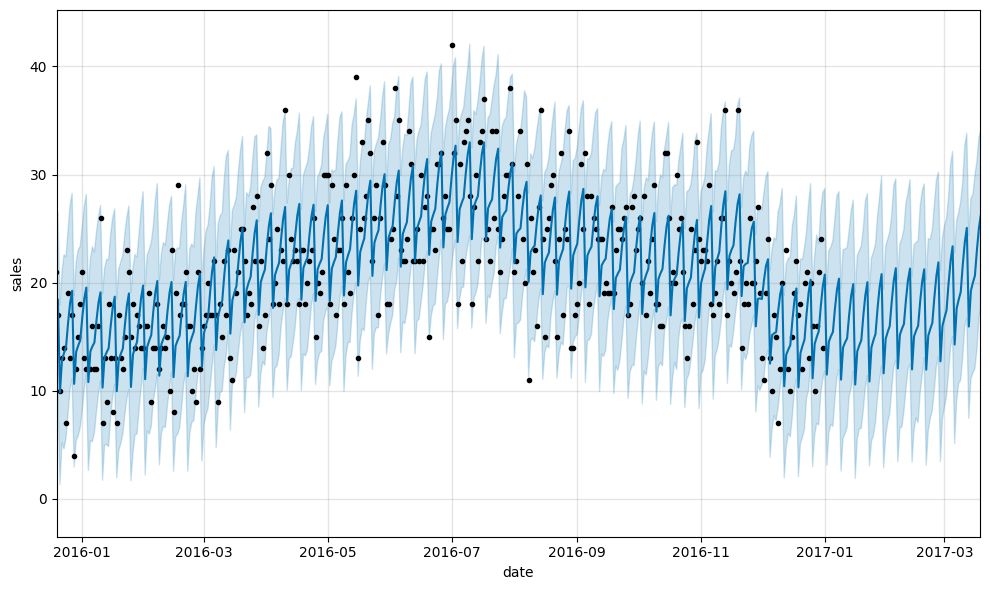

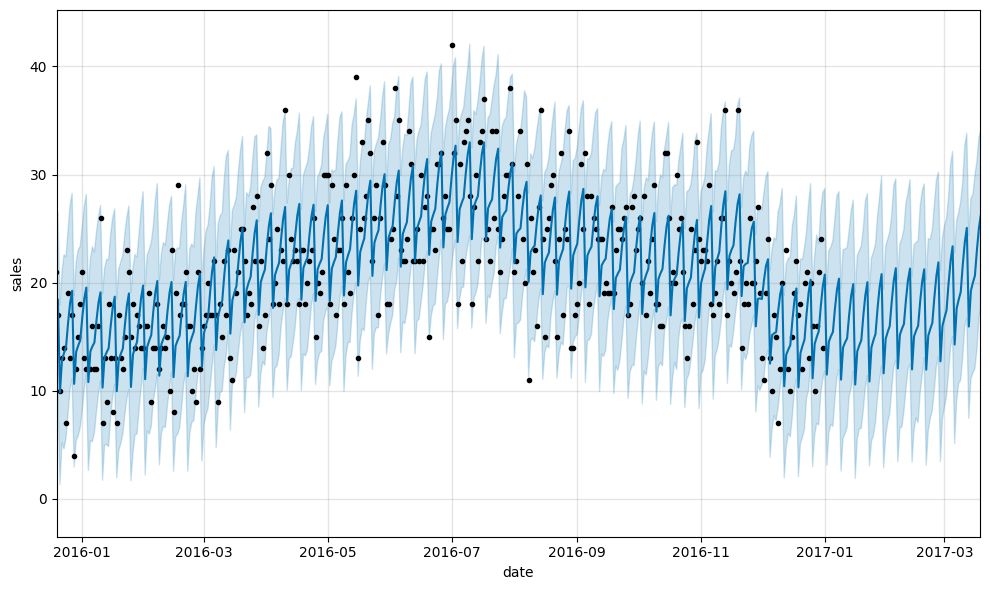

In [56]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

## Evaluation Metrics

In [57]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# get historical actuals & predictions for comparison
actuals_pd = history_pd[ history_pd['ds'] < date(2014, 1, 1) ]['y']
predicted_pd = forecast_pd[ forecast_pd['ds'] < pd.to_datetime('2014-01-01') ]['yhat']

# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 3.149124071533445
MSE: 16.23398329422517
RMSE: 4.029141756531429


# Scale Forecast Generation

## Get Data for All Store-Item Combinations

In [58]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as date) as ds,
    SUM(sales) as y
  FROM train_df
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

sc = spark.sparkContext

store_item_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
  ).cache()

## Define Schema

In [59]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

## Function to Train Model & Generate Forecast

In [61]:
def forecast_store_item( history_pd: pd.DataFrame ) -> pd.DataFrame:

  # TRAIN MODEL AS BEFORE
  # --------------------------------------
  # remove missing values (more likely at day-store-item level)
  history_pd = history_pd.dropna()

  # configure the model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )

  # train the model
  model.fit( history_pd )
  # --------------------------------------

  # BUILD FORECAST AS BEFORE
  # --------------------------------------
  # make predictions
  future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
    )
  forecast_pd = model.predict( future_pd )
  # --------------------------------------

  # ASSEMBLE EXPECTED RESULT SET
  # --------------------------------------
  # get relevant fields from forecast
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')

  # get relevant fields from history
  h_pd = history_pd[['ds','store','item','y']].set_index('ds')

  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)

  # get store & item from incoming data set
  results_pd['store'] = history_pd['store'].iloc[0]
  results_pd['item'] = history_pd['item'].iloc[0]
  # --------------------------------------

  # return expected dataset
  return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [62]:
from pyspark.sql.functions import current_date

results = (
  store_item_history
    .groupBy('store', 'item')
      .applyInPandas(forecast_store_item, schema=result_schema)
    .withColumn('training_date', current_date() )
    )

results.createOrReplaceTempView('new_forecasts')

display(results)

DataFrame[ds: date, store: int, item: int, y: float, yhat: float, yhat_upper: float, yhat_lower: float, training_date: date]

## Persist Results

In [25]:
results.write.mode("overwrite").parquet("/content/new_forecasts.parquet")

## Evaluate Forecast

In [63]:
# schema of expected result set
eval_schema =StructType([
  StructField('training_date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('mae', FloatType()),
  StructField('mse', FloatType()),
  StructField('rmse', FloatType())
  ])

# define function to calculate metrics
def evaluate_forecast( evaluation_pd: pd.DataFrame ) -> pd.DataFrame:

  # get store & item in incoming data set
  training_date = evaluation_pd['training_date'].iloc[0]
  store = evaluation_pd['store'].iloc[0]
  item = evaluation_pd['item'].iloc[0]

  # calculate evaluation metrics
  mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  rmse = sqrt( mse )

  # assemble result set
  results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
  return pd.DataFrame.from_dict( results )

# calculate metrics
results = (
  spark
    .table('new_forecasts')
    .filter('ds < \'2017-01-01\'') # limit evaluation to periods where we have historical data
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .applyInPandas(evaluate_forecast, schema=eval_schema)
    )

results.createOrReplaceTempView('new_forecast_evals')

## Show Results

In [64]:
# Show the results using Spark SQL
spark.sql("SELECT * FROM new_forecast_evals").show()

+-------------+-----+----+---------+---------+---------+
|training_date|store|item|      mae|      mse|     rmse|
+-------------+-----+----+---------+---------+---------+
|   2024-11-03|    1|   1| 3.399598|18.602667| 4.313081|
|   2024-11-03|    1|   5|3.1563182|15.896082| 3.986989|
|   2024-11-03|    1|   6| 5.887287| 55.02441| 7.417844|
|   2024-11-03|    1|   7| 5.919438|56.490417|7.5160108|
|   2024-11-03|    1|  10| 6.753251| 72.07192| 8.489518|
|   2024-11-03|    1|  11| 6.466728| 65.49742| 8.093048|
|   2024-11-03|    1|  13|7.1699405| 79.76549| 8.931152|
|   2024-11-03|    1|  16|3.7887948| 22.74224|4.7688828|
|   2024-11-03|    1|  17|4.3552613|29.939821|5.4717293|
|   2024-11-03|    1|  18| 7.196905|  82.1103| 9.061473|
|   2024-11-03|    1|  19|5.0653777| 39.77793| 6.306975|
|   2024-11-03|    1|  20| 5.053354|40.820805|6.3891163|
|   2024-11-03|    1|  21|  4.77695| 36.31468| 6.026166|
|   2024-11-03|    1|  22|  7.23155| 81.56071| 9.031096|
|   2024-11-03|    1|  25| 6.89

# Number of Partitions

In [65]:
num_partitions = store_item_history.rdd.getNumPartitions()
print(f"Number of partitions in store_item_history: {num_partitions}")

Number of partitions in store_item_history: 2


# Parallelise Evaluation Forecast

In [45]:
# Define function to calculate metrics
def evaluate_forecast(evaluation_pd: pd.DataFrame) -> pd.DataFrame:
    # Get store & item in incoming data set
    training_date = evaluation_pd['training_date'].iloc[0]
    store = evaluation_pd['store'].iloc[0]
    item = evaluation_pd['item'].iloc[0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(evaluation_pd['y'], evaluation_pd['yhat'])
    mse = mean_squared_error(evaluation_pd['y'], evaluation_pd['yhat'])
    rmse = sqrt(mse)

    # Assemble result set
    results = {
        'training_date': [training_date],
        'store': [store],
        'item': [item],
        'mae': [mae],
        'mse': [mse],
        'rmse': [rmse]
    }
    return pd.DataFrame.from_dict(results)

# Repartition the DataFrame to optimize parallel processing
new_forecasts_df = new_forecasts_df.repartition(12, 'store', 'item')  # Adjust the number of partitions as needed

In [46]:
print(f"Number of partitions before: {new_forecasts_df.rdd.getNumPartitions()}")

# Calculate metrics
results = (
    new_forecasts_df
    .groupBy('training_date', 'store', 'item')
    .applyInPandas(evaluate_forecast, schema=eval_schema)
)

print(f"Number of partitions after: {results.rdd.getNumPartitions()}")

Number of partitions before: 12
Number of partitions after: 12


In [47]:
# Create or replace temporary view for further use
results.createOrReplaceTempView('new_forecast_evals')

# Optionally, show the results
results.show()

+-------------+-----+----+---------+----------+---------+
|training_date|store|item|      mae|       mse|     rmse|
+-------------+-----+----+---------+----------+---------+
|   2024-11-03|    1|  16|3.6370947| 21.260578|4.6109195|
|   2024-11-03|    1|  30|  4.18012| 28.979706|5.3832803|
|   2024-11-03|    1|  37|3.6484478| 20.955252|4.5776906|
|   2024-11-03|    2|  28|7.3029084|  88.49532| 9.407195|
|   2024-11-03|    2|  46| 6.680476| 69.342705| 8.327227|
|   2024-11-03|    2|  50|7.1708317|  83.82744| 9.155732|
|   2024-11-03|    3|  18|7.2746844|  87.78812| 9.369532|
|   2024-11-03|    3|  47|3.2844663| 16.964361|4.1187816|
|   2024-11-03|    4|   5|3.0531607|14.8466835|3.8531394|
|   2024-11-03|    4|  50| 6.099222|  62.65799|  7.91568|
|   2024-11-03|    5|  18|5.6825786|  50.70182| 7.120521|
|   2024-11-03|    5|  39| 4.088636|  26.01586|5.1005745|
|   2024-11-03|    5|  45|6.1392164|  59.08563|7.6867175|
|   2024-11-03|    6|   5| 2.531757| 10.490792|3.2389493|
|   2024-11-03